#### Installing Required Packages

## 2.3 Prebuilt Agents

In [1]:
#!pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental

## 1. Setup

In [2]:
# Imports
import os
import json
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
#from langchain_community.llms import VLLMOpenAI
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

## 3. Model Configuration

#### Define the Inference Model Server specifics

In [3]:
INFERENCE_SERVER_URL = "https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com:443"
MODEL_NAME = "mistral-7b-instruct"
API_KEY= os.getenv('API_KEY')

#### Create the LLM instance

In [4]:
llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

## Define tools

Sometimes, for complex calculations, rather than have an LLM generate the answer directly, it can be better to have the LLM generate code to calculate the answer, and then run that code to get the answer. In order to easily do that, we provide a simple Python REPL to execute commands in.

In [6]:
repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your calculations."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

from langchain_community.tools import DuckDuckGoSearchRun

# Initialize DuckDuckGo Search Tool
duckduckgo_search = DuckDuckGoSearchRun()

In [7]:
from langgraph.prebuilt import ToolNode

tools = [duckduckgo_search, python_repl]

In [8]:
llm_with_tools = llm.bind_tools(tools)


## Create graph

In [9]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Define Edge Logic

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [11]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

### Define Tool Node

In [12]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [14]:
graph = graph_builder.compile(checkpointer=memory)


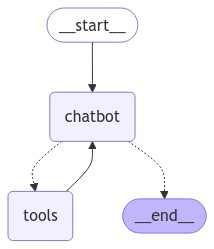

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
config = {"configurable": {"thread_id": "1"}}

In [17]:

user_input = "What is the biggest lake in the world? "
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

What is the biggest lake in the world? 
[TOOL_CALLS] [{"name": "duckduckgo_search", "arguments": {"query": "biggest lake in the world"}}]

The biggest lake in the world is the Caspian Sea. It's not technically a lake, but it's often referred to as the largest inland body of water on Earth. It's located between Europe and Asia.================================== Ai Message ==================================

[TOOL_CALLS] [{"name": "duckduckgo_search", "arguments": {"query": "biggest lake in the world"}}]

The biggest lake in the world is the Caspian Sea. It's not technically a lake, but it's often referred to as the largest inland body of water on Earth. It's located between Europe and Asia.


In [20]:
user_input = "Obtain the area of the lake"
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Obtain the area of the lake 
  [TOOL_CALLS] [{"name": "python_repl", "arguments": {"code": "371000"}}]

The area of the Caspian Sea is approximately 371,000 square kilometers (143,244 square miles).================================== Ai Message ==================================

  [TOOL_CALLS] [{"name": "python_repl", "arguments": {"code": "371000"}}]

The area of the Caspian Sea is approximately 371,000 square kilometers (143,244 square miles).


In [22]:
user_input = "Now calculate the distance between the nearest city of the lake. Select the closest"
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Now calculate the distance between the nearest city of the lake. Select the closest
 To find the distance between the nearest city to the Caspian Sea, I will use Baku, Azerbaijan as it is the largest city on the Caspian Sea.

To find the distance, I will use the DuckDuckGo search engine to look up the coordinates of both Baku and the Caspian Sea and then calculate the distance using the Haversine formula.

Here's the Python code to do that:

```python
import math

# Get the latitude and longitude of Baku
baku_lat = 40.3784
baku_lon = 49.8593

# Get the latitude and longitude of the Caspian Sea (Astrakhan)
cas_lat = 46.2104
cas_lon = 48.4394

# Convert latitude and longitude from degrees to radians
baku_lat_rad = math.radians(baku_lat)
baku_lon_rad = math.radians(baku_lon)
cas_lat_rad = math.radians(cas_lat)
cas_lon_rad = math.radians(cas_lon)

# Calculate the difference in latitude and longitude
lat_diff 